# Rupaul's Drag Race Machine

In [75]:
#%matplotlib inline

import pandas as pd
import numpy as np
import math, random
from scipy.stats import rankdata, kendalltau
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt

theData = pd.read_csv("dragrace9.csv")
theData= theData.fillna(0)
#theData.iloc[1:10,:]

In [76]:
queens = theData
queens.shape

(114, 18)

In [77]:
# create a function to scale the data for us
def scaleQueens(df):
    """Scale Age, Wins, Highs, Lows, and Lipsyncs in feature data frames"""
    df = df.copy(deep=True)
    df['Age'] = scale(df['Age'])
    df['Wins'] = scale(df['Wins'])
    df['Highs'] = scale(df['Highs'])
    df['Lows'] = scale(df['Lows'])
    df['Lipsyncs'] = scale(df['Lipsyncs'])
    df['Season'] = df['Season']/9
    return df

In [78]:
def compareRanks(x,y):
    x=np.asarray(x)
    y=np.asarray(y)
    numRanks = np.append(x,y).max()
    actual=np.sum(np.square(x-y))
    worst=np.sum(np.square(np.sort(x)-np.sort(x)[::-1]))
    return 1-2*(actual/worst)

In [79]:
def createPD(s,queens,yfitpd):
    season = queens.loc[queens.Season==s,['Name','Place']]
    seasonpred = yfitpd.loc[queens.Season==s]
    season['Predicted'] = seasonpred
    season['Predicted'] = rankdata(season.Predicted,method='min')
    season = season.sort_values('Place')
    return season

In [80]:
def predictSeason(season,model,queens,scaled=False):
    Xtrain = queens.loc[queens.Season!=season,['Age','PuertoRico','PlusSize','Wins','Highs','Lows','Lipsyncs','Season']]
    Xtest = queens.loc[queens.Season==season,['Age','PuertoRico','PlusSize','Wins','Highs','Lows','Lipsyncs','Season']]
    ytrain = queens.loc[queens.Season!=season,'Place']
    if scaled:
        Xtrain = scaleQueens(Xtrain)
        Xtest = scaleQueens(Xtest)
    model.fit(Xtrain,ytrain)
    yfit = model.predict(Xtest)
    pddf = queens.loc[queens.Season==season,['Name','Place']]
    pddf['Predicted'] = rankdata(yfit,method='min')
    return pddf

In [81]:

class neural_network:
    """Defines a neural network, along with attributes for fitting and predicting the network"""
    def __init__(self,size):
        random.seed(0)
        self.network = []
        for i in range(1,len(size)):
            self.network.append([[random.random() for __ in range(size[i-1] + 1)] for __ in range(size[i])])
    
    def sigmoid(self,t): 
        return 1 / (1 + math.exp(-t))
    
    def neuron_output(self,weights, inputs):   #This is a simpler representation; weights for input plus one extra (bias)
        return self.sigmoid(np.dot(weights, inputs))
    
    def feed_forward(self,input_vector):
        outputs = []

        for layer in self.network: #Remember the neural network is given as a list of "layers" which have neurons in them

            input_with_bias = input_vector + [1]          # add a bias input (this just allos us to use a dot product)
            output = [self.neuron_output(neuron, input_with_bias) # compute the output
                      for neuron in layer]                   # for this layer
            outputs.append(output)                           # and remember it

            # the input to the next layer is the output of this one
            input_vector = output

        return outputs
    
    def predict(self,X):
        X = scaleQueens(X)
        predictedY = []
        X = X.values.tolist()
        for i, input in enumerate(X):
            outputs = self.feed_forward(input)[-1]
            predictedY.append(outputs)
        predictedPlace = [a.index(max(a)) for a in predictedY]
        return predictedPlace
    
    
    def convertY(self,Y):
        yNN = [[1 if i == (j-1) else 0 for i in range(0,len(Y)-1)]
               for j in Y ]
        return(yNN)
    
    # define the back-propagation that allows the network to learn
    def backpropagate(self, input_vector, target):
        hidden_outputs, outputs = self.feed_forward(input_vector)

        # the output * (1 - output) is from the derivative of sigmoid
        output_deltas = [output * (1 - output) * (output - target[i])
                         for i, output in enumerate(outputs)]

        # adjust weights for output layer (network[-1])
        for i, output_neuron in enumerate(self.network[-1]):
            for j, hidden_output in enumerate(hidden_outputs + [1]):
                output_neuron[j] -= output_deltas[i] * hidden_output

        # back-propagate errors to hidden layer
        hidden_deltas = [hidden_output * (1 - hidden_output) * 
                          np.dot(output_deltas, [n[i] for n in self.network[-1]]) 
                         for i, hidden_output in enumerate(hidden_outputs)]

        # adjust weights for hidden layer (network[0])
        for i, hidden_neuron in enumerate(self.network[0]):
            for j, input in enumerate(input_vector + [1]):
                hidden_neuron[j] -= hidden_deltas[i] * input
    
    def fit(self,features,targets,times=10000):
        features = scaleQueens(features)
        targets = self.convertY(targets)
        features = features.values.tolist()
        for i in range(times):
            for X, Y in zip(features, targets):
                self.backpropagate(X,Y)
        
        
        

In [82]:

class neural_network:
    """Defines a neural network, along with attributes for fitting and predicting the network"""
    def __init__(self,model):
        self.network = model
    
    def sigmoid(self,t): 
        return 1 / (1 + math.exp(-t))
    
    def neuron_output(self,weights, inputs):   #This is a simpler representation; weights for input plus one extra (bias)
        return self.sigmoid(np.dot(weights, inputs))
    
    def feed_forward(self,input_vector):
        outputs = []

        for layer in self.network: #Remember the neural network is given as a list of "layers" which have neurons in them

            input_with_bias = input_vector + [1]          # add a bias input (this just allos us to use a dot product)
            output = [self.neuron_output(neuron, input_with_bias) # compute the output
                      for neuron in layer]                   # for this layer
            outputs.append(output)                           # and remember it

            # the input to the next layer is the output of this one
            input_vector = output

        return outputs
    
    def predict(self,X):
        predictedY = self.network.predict(X)
        X = X.values.tolist()
        predictedPlace = [a.index(max(a)) for a in predictedY]
        return predictedPlace
    
    
    def convertY(self,Y):
        yNN = [[1 if i == (j-1) else 0 for i in range(0,len(Y)-1)]
               for j in Y ]
        return(yNN)
    
    # define the back-propagation that allows the network to learn
    def backpropagate(self, input_vector, target):
        hidden_outputs, outputs = self.feed_forward(input_vector)

        # the output * (1 - output) is from the derivative of sigmoid
        output_deltas = [output * (1 - output) * (output - target[i])
                         for i, output in enumerate(outputs)]

        # adjust weights for output layer (network[-1])
        for i, output_neuron in enumerate(self.network[-1]):
            for j, hidden_output in enumerate(hidden_outputs + [1]):
                output_neuron[j] -= output_deltas[i] * hidden_output

        # back-propagate errors to hidden layer
        hidden_deltas = [hidden_output * (1 - hidden_output) * 
                          np.dot(output_deltas, [n[i] for n in self.network[-1]]) 
                         for i, hidden_output in enumerate(hidden_outputs)]

        # adjust weights for hidden layer (network[0])
        for i, hidden_neuron in enumerate(self.network[0]):
            for j, input in enumerate(input_vector + [1]):
                hidden_neuron[j] -= hidden_deltas[i] * input
    
    def fit(self,features,targets,times=10000):
        targets = self.convertY(targets)
        self.network.fit()
        
        
        

In [83]:
MLPClassifier?

Initialize the models

In [84]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier

svc_model = SVC(kernel='rbf',gamma=0.01,C=10)
gnb_model = GaussianNB()
rfc_model = RandomForestClassifier(n_estimators=100, random_state=0)
rfr_model = RandomForestRegressor(200,random_state=24601)
nn_model = neural_network([8,5,14])
nn2_model=MLPClassifier(hidden_layer_sizes=(5,),
                       activation='logistic',
                       solver='lbfgs',
                       random_state=24601)

Have each model predict the rankings and save to a data frame


In [85]:
predictSeason(9,nn2_model,queens,True)

//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


,Name,Place,Predicted
101,Aja,0.0,1
102,Alexis Michelle,0.0,11
103,Charlie Hides,0.0,9
104,Eureka,0.0,4
105,Farrah Moan,0.0,1
106,Jaymes Mansfield,0.0,4
107,Kimora Blac,0.0,4
108,Nina Bo'Nina Brown,0.0,11
109,Peppermint,0.0,9
110,Sasha Velour,0.0,4


In [86]:
the_models = [gnb_model,rfc_model,rfr_model,nn2_model]
model_names = ["GNB","RFC","RFR","NN"]
season = predictSeason(9,svc_model,queens,True)
season['Season'] = 9
season['Model'] = 'SVC'
rank_score = compareRanks(season.Place,season.Predicted)
rsdf = pd.DataFrame({'Season': [9], 'Value': [rank_score], 'Model': ['SVM']})
pred_df = season
rank_scores = rsdf.copy(deep=True)
n = 0
for model in the_models:
    season = predictSeason(9,model,queens,True)
    season['Season'] = 9
    season['Model'] = model_names[n]
    pred_df = pred_df.append(season)
    rank_score = compareRanks(season.Place,season.Predicted)
    rsdf = pd.DataFrame({'Season': [9], 'Value': [rank_score], 'Model': [model_names[n]]})
    rank_scores = rank_scores.append(rsdf)
    n += 1


//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)
//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)
//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


In [87]:
resultsTable = pred_df.pivot_table(index=('Name','Place','Season'),columns='Model').sortlevel(['Season','Place'])
resultsTable['mean'] = resultsTable.mean(axis=1)

In [88]:
resultsTable.to_csv('PredictedSeason9.csv')

In [89]:
resultsTable.sort_values(by='mean')

Predicted                 mean
Model                                 GNB  NN RFC RFR SVC     
Name               Place Season                               
Kimora Blac        0.0   9              1   4   1   1   3  2.0
Valentina          0.0   9              1   1   1   5   3  2.2
Shea Coulee        0.0   9              1   4   1   3   3  2.4
Charlie Hides      0.0   9              1   9   1   1   1  2.6
Farrah Moan        0.0   9              1   1   1   8   3  2.8
Aja                0.0   9              1   1   1   9   3  3.0
Peppermint         0.0   9              1   9   1   4   1  3.2
Sasha Velour       0.0   9              1   4   1  11   3  4.0
Alexis Michelle    0.0   9              1  11   1   6   3  4.4
Trinity Taylor     0.0   9              1  11   1   7   3  4.6
Nina Bo'Nina Brown 0.0   9              1  11   1   9   3  5.0
Jaymes Mansfield   0.0   9             12   4   1  12  12  8.2
Eureka             0.0   9             12   4   1  13  12  8.4

In [90]:
rank_scores

,Model,Season,Value
0,SVM,9,-inf
0,GNB,9,-inf
0,RFC,9,-inf
0,RFR,9,-inf
0,NN,9,-inf


# Based on Princess Points

A group of drag race super fans scored the meet the queens videos for season 8, and then again for season 9. The results below train on season 8 only and then predict season 9.

In [91]:
def predictSeasonPrincess(season,model,queens,scaled=False):
    Xtrain = queens.loc[queens.Season==8,['Age','PuertoRico','PlusSize','Season','PrincessPoints']]
    Xtest = queens.loc[queens.Season==9,['Age','PuertoRico','PlusSize','Season','PrincessPoints']]
    ytrain = queens.loc[queens.Season==8,'Place']
    if scaled:
        Xtrain = scaleQueensPrincess(Xtrain)
        Xtest = scaleQueensPrincess(Xtest)
    model.fit(Xtrain,ytrain)
    yfit = model.predict(Xtest)
    pddf = queens.loc[queens.Season==9,['Name','Place']]
    pddf['Predicted'] = rankdata(yfit,method='min')
    return pddf

In [92]:
# create a function to scale the data for us
def scaleQueensPrincess(df):
    """Scale Age, Wins, Highs, Lows, and Lipsyncs in feature data frames"""
    df = df.copy(deep=True)
    df['Age'] = scale(df['Age'])
    df['PrincessPoints'] = scale(df['PrincessPoints'])
    df['Season'] = df['Season']/9
    return df

In [104]:
the_models = [gnb_model,rfc_model,rfr_model,nn2_model]
model_names = ["GNB","RFC","RFR","NN"]
season = predictSeasonPrincess(9,svc_model,queens,True)
season['Season'] = 9
season['Model'] = 'SVC'
rank_score = compareRanks(season.Place,season.Predicted)
rsdf = pd.DataFrame({'Season': [9], 'Value': [rank_score], 'Model': ['SVM']})
pred_df = season
rank_scores = rsdf.copy(deep=True)
n = 0
for model in the_models:
    if model_names[n] == "GNB" or model_names[n] == "NN":
        season = predictSeasonPrincess(9,model,queens,True)
    else:
        season = predictSeasonPrincess(9,model,queens,False)
    season['Season'] = 9
    season['Model'] = model_names[n]
    pred_df = pred_df.append(season)
    rank_score = compareRanks(season.Place,season.Predicted)
    rsdf = pd.DataFrame({'Season': [9], 'Value': [rank_score], 'Model': [model_names[n]]})
    rank_scores = rank_scores.append(rsdf)
    n += 1

//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)
//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


In [105]:
resultsTable = pred_df.pivot_table(index=('Name','Place','Season'),columns='Model').sortlevel(['Season','Place'])
resultsTable['mean'] = resultsTable.mean(axis=1)
resultsTable = resultsTable.sort_values(by='mean')
resultsTable.to_csv("princessPredictions9.csv")
resultsTable

Predicted                 mean
Model                                 GNB  NN RFC RFR SVC     
Name               Place Season                               
Valentina          0.0   9              1   1   1   2   4  1.8
Jaymes Mansfield   0.0   9              1   1   1   4   4  2.2
Eureka             0.0   9              1   6   5   1   1  2.8
Kimora Blac        0.0   9              1   6   1   6   4  3.6
Sasha Velour       0.0   9              1   1   9   3   4  3.6
Shea Coulee        0.0   9              1   6   1   7   4  3.8
Trinity Taylor     0.0   9              1   5   6   9   1  4.4
Alexis Michelle    0.0   9              1   6   7   8   4  5.2
Farrah Moan        0.0   9              1   4   9  10   4  5.6
Aja                0.0   9              1  12   9   5   4  6.2
Peppermint         0.0   9              1  10   7  13   3  6.8
Charlie Hides      0.0   9              1  10   9  12   4  7.2
Nina Bo'Nina Brown 0.0   9              1  12   9  11   4  7.4

# Just for Fun: Visualizing

In [109]:
from sklearn.decomposition import PCA
import seaborn as sb
sb.set_style("dark")
import matplotlib.pyplot as plt
%pylab inline

pca = PCA(n_components=2)

Populating the interactive namespace from numpy and matplotlib


//anaconda/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [110]:
Xtrain = queens.loc[queens.Season!=9,['Age','PuertoRico','PlusSize','Wins','Highs','Lows','Lipsyncs','Season']]
ytrain = queens.loc[queens.Season!=9,'Place']

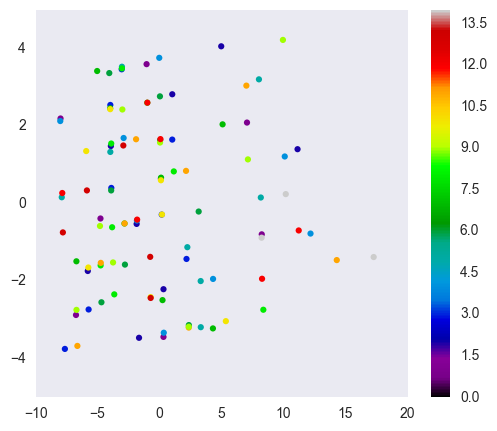

In [112]:
pca.fit(Xtrain)
transform = pca.transform(Xtrain)

figure(figsize(6,5))
plt.scatter(transform[:,0],transform[:,1], s=20, c = ytrain, cmap = "nipy_spectral", edgecolor = "None")
plt.colorbar()
clim(0,14)